In [1]:
# Math stuff
import numpy as np
# For handling dataset
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# Model used as a benchmark
from sklearn.svm import OneClassSVM
# For undersampling
from imblearn.under_sampling import RandomUnderSampler
# metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
# 
from sklearn.model_selection import GridSearchCV

In [2]:
# loading the dataset
df = pd.read_csv('creditcard.csv')
df = df[['V11', 'V15', 'V18', 'Class']]

In [3]:
X, y = df.iloc[:,:-1].copy(), df.iloc[:,-1:].copy()

The OneClassSVM classifier split out as result 1 and -1. <br />
So, we must adapt our y (labels).

In [4]:
y.Class[y.Class==1] = -1 # anomalous will be -1
y.Class[y.Class==0] = 1

In [5]:
# This custom auc is due to the labels -1 and 1.
# The true positive should be 1, so I'll be changing the signs before submiting the metric
def custom_auc(y_true, y_pred):
    y_pred *= -1
    y_true *= -1
    return average_precision_score(y_true=y_true, y_score=y_pred)
scoring = make_scorer(custom_auc, greater_is_better=True)

In [6]:
nu = len(y.Class[y.Class==-1])/float(len(y))
print nu

# trying some parameters
params = { 'kernel':['rbf'], \
    'nu':[nu, .1, 0.261, .5, .75, .8], \
    'gamma':[.00005, .0005, .005, .05, .5]}

0.00172748563062


In [7]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=OneClassSVM(), param_grid=params, n_jobs=1, scoring=scoring)

Doing the undersample without the fraud. <br />
Since it's a One-class classifier, the main idea is to model one class. <br />
In this case, the legit ones.

In [8]:
rus = RandomUnderSampler(random_state=0, ratio={1:15000, -1:0}, return_indices=True)

In [9]:
X_resampled, y_resampled, idxs = rus.fit_sample(X, y.Class)
X_resampled = pd.DataFrame(X_resampled)
X_resampled.columns = df.columns[:-1]

In [10]:
clf.fit(X_resampled, y_resampled)

C:\Users\rodrigo.silva\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


GridSearchCV(cv=None, error_score='raise',
       estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'nu': [0.001727485630620034, 0.1, 0.261, 0.5, 0.75, 0.8], 'gamma': [5e-05, 0.0005, 0.005, 0.05, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_auc), verbose=0)

In [11]:
# printing the best estimator
clf.best_estimator_

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.00172748563062, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [12]:
y_pred = clf.predict(X)
y_true = y
print len(y_pred[y_pred==1])
print len(y_pred[y_pred==-1])

284125
682


Let's compare the predictions with the actual scenario

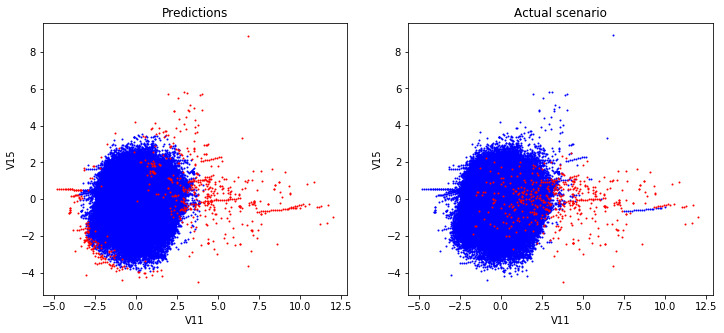

In [13]:
isLegit = y_pred == 1

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X[isLegit].V11, X[isLegit].V15, c='b', s=1, label='legit')
plt.scatter(X[~isLegit].V11, X[~isLegit].V15, c='r', s=1, label='fraud')

plt.title('Predictions')
plt.xlabel('V11')
plt.ylabel('V15')

plt.subplot(122)
isLegit = df.Class == 0
plt.scatter(X[isLegit].V11, X[isLegit].V15, c='b', s=1, label='legit')
plt.scatter(X[~isLegit].V11, X[~isLegit].V15, c='r', s=1, label='fraud')

plt.title('Actual scenario')
plt.xlabel('V11')
plt.ylabel('V15')

plt.show()

In [14]:
confusion_matrix(y_pred=y_pred*-1, y_true=y_true*-1)

array([[283903,    412],
       [   222,    270]], dtype=int64)

In [15]:
precision, recall, _ = precision_recall_curve(y_pred*-1, y_true*-1)
auc = average_precision_score(y_true=y_true*-1, y_score=y_pred*-1)

print 'precision %.7f' % precision[1]
print 'recall %.7f' % recall[1]
print 'auc %.7f' % auc

precision 0.5487805
recall 0.3958944
auc 0.2180386


By looking on the plot, it seems that the classifier did a good job. <br />
However the metrics tell us that the performance was lower than the GaussianNB (the NB auc was .36).

In [16]:
def minmax(x):
    return min(x), max(x)

In [17]:
xmin, xmax = minmax(X.V11)
ymin, ymax = minmax(X.V15)
zmin, zmax = minmax(X.V18)

xx, yy, zz = np.mgrid[xmin:xmax:.5, ymin:ymax:.5, zmin:zmax:.5]

In [18]:
Z = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = clf.best_estimator_.decision_function(Z)
Z = np.reshape(Z, xx.shape)

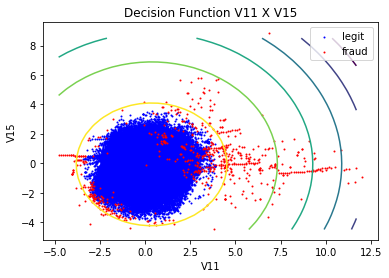

In [19]:
plt.contour(xx[:,:,0], yy[:,:,0], Z[:,:,0], level=[0])

isLegit = y_pred == 1
plt.scatter(X[isLegit].V11, X[isLegit].V15, s=1, c='b', label='legit')
plt.scatter(X[~isLegit].V11, X[~isLegit].V15, s=1, c='r', label='fraud')

plt.title('Decision Function V11 X V15')
plt.xlabel('V11')
plt.ylabel('V15')
plt.legend()
plt.show()

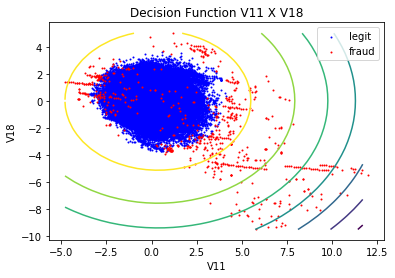

In [20]:
plt.contour(xx[:,0,:], zz[:,0,:], Z[:,0,:])

plt.scatter(X[isLegit].V11, X[isLegit].V18, s=1, c='b', label='legit')
plt.scatter(X[~isLegit].V11, X[~isLegit].V18, s=1, c='r', label='fraud')

plt.title('Decision Function V11 X V18')
plt.xlabel('V11')
plt.ylabel('V18')
plt.legend()
plt.show()

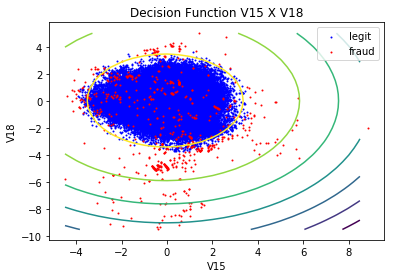

In [21]:
plt.contour(yy[0,:,:], zz[0,:,:], Z[0,:,:])

plt.scatter(X[isLegit].V15, X[isLegit].V18, s=1, c='b', label='legit')
plt.scatter(X[~isLegit].V15, X[~isLegit].V18, s=1, c='r', label='fraud')

plt.title('Decision Function V15 X V18')
plt.xlabel('V15')
plt.ylabel('V18')
plt.legend()
plt.show()

By taking a look on the predictions and the contour plots, we can see that most of the transactions next to the inner circle was predicted as fraudulents. <br />
There is a trade-off between predicting the frauds, but trying to avoid too many false positives. <br />
If we want to increase the precision power, this might decrease the recall power. <br />
It means that by preventing a fraud might restrain a legit user to spend his money. <br />